In [141]:
# Importing the relevant libraries
from numba import njit                        # to speed up code
import numpy as np
import matplotlib.pyplot as plt

## Equations
### Main D.E. (without random force) - $ \frac{d^2x}{dt^2} + \gamma \frac{dx}{dt} = 0 $
### Analytical Solutions (general form)
 $ x(t) = C_1(e^{-\gamma t}) + C_2 \hspace{0.5cm} v(t) = -C_1\gamma e^{-\gamma t} $ 
 
 $ C_1 = -\frac{V_0}{\gamma}, C_2 = X_0 + \frac{V_0}{\gamma} $
#### Einstein Relation for $D$ -
$ \langle{x^2}\rangle = 2Dt $

## Defining modified rk4 integrator function - 

In [110]:
@njit 
def rk4_new(X0, V0, Tf, dt, g):
    
    # Initializing arrays for X,V,T,E and random force F to accept float values
    N = np.int(Tf/dt)
    X = np.zeros(N+1, np.float32)                        # Displacement array
    V = np.zeros(N+1, np.float32)                        # Velocity array
    T = np.zeros(N+1, np.float32)                        # Time array
    E = np.zeros(N+1, np.float32)                        # Energy array
    F = np.zeros(N+1, np.float32)                        # Random Force array
    
    # Assigning first values of X and V arrays to the initial displacement(X0) & velocity(V0) respectively
    X[0] = X0
    V[0] = V0
    
    # Defining the acceleration function
    def acc(x,v,g,F):                                                
        return 0*x - v*g + F 
    
    # Defining the energy (per unit mass) function
    def ener_m(x,v,g):
        return x*v*g
    
    # RK4 integration loop
    for n in range(1, N+1):
        T[n] = n*dt                    # Fills the time array 'T' with [0, dt, 2*dt, 3*dt,..... Tf]
        x0 = X[n-1]
        v0 = V[n-1]
        h  = dt   
        
        # generating random F (a float number)
        F[n] = np.random.uniform(-1,1)                                

        k1x = v0
        k1v = acc(x0, v0, g, F[n])
        k2x = v0 + (k1v*h/2)
        k2v = acc((x0 + (k1x*h/2)), (v0 + (k1v*h/2)), g, F[n])        # using same F in acc function
        k3x = v0 + (k2v*h/2)
        k3v = acc((x0 + (k2x*h/2)), (v0 + (k2v*h/2)), g, F[n])
        k4x = v0 + (k3v*h)
        k4v = acc(x0 + (k3x*h), v0 + (k3v*h), g, F[n])
        
        # Updating the X,V,E arrays in every loop
        X[n] = x0 + (dt*(k1x + 2*k2x + 2*k3x + k4x)/6)
        V[n] = v0 + (dt*(k1v + 2*k2v + 2*k3v + k4v)/6)
        E[n] = ener_m(X[n], V[n], g)
        
    return T, X, V, E


### Plotting simple rk4_new without averaging (jagged paths) 

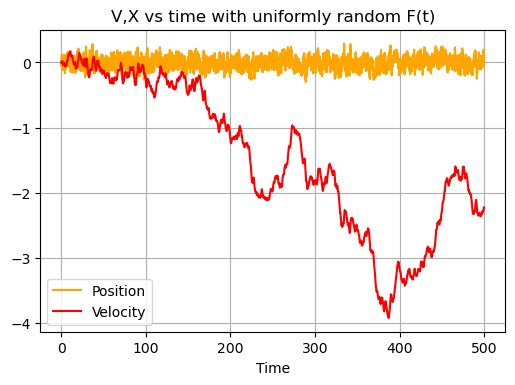

In [137]:
t3,v3,x3,e3 = rk4_new(0,0,500,0.1,2)
plt.plot(t3,x3, color="orange", label="Position")
plt.plot(t3,v3, color="red", label="Velocity")
plt.title("V,X vs time with uniformly random F(t)")
plt.xlabel("Time")

# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

plt.legend()
plt.grid()
plt.show()

###### Change range of random number F to be assymetric about 0 to observe biased randomisation 

In [112]:
# Defining a function for polyfitting data (to get values of Diffusion coefficient D)
def fit(x,y):
    m,c = np.polyfit(x,y,1)
    return m,c

#### Speed-testing the code to see if numba works without any error

In [113]:
%%time
t2,x2,v2,e2 = rk4_new(0,0,100,0.1,3)

Wall time: 0 ns


## Averaging $x, x^2, v, v^2$ over 1000 trials 

#### Initial Conditions -

In [116]:
Xin = 0              # initial position
Vin = 0              # initial velocity
trials = 1000        # no. of trials
T = 500              # time ran for each trial (in sec)
dt = 0.1             # time step
gamma = 0.8          # gamma value

#### Making 4 empty arrays (for $x,x^2,v,v^2$) to fill in values later

In [117]:
avg_arr_x   = np.empty([trials,int(T/dt)+1], float)                # 2D array for x
avg_arr_xsq = np.empty([trials,int(T/dt)+1], float)                # 2D array for x^2
avg_arr_v   = np.empty([trials,int(T/dt)+1], float)                # 2D array for v
avg_arr_vsq = np.empty([trials,int(T/dt)+1], float)                # 2D array for v^2

#### Looping to fill all 4 empty arrays (row-wise) 

In [118]:
%%time                                                  
for i in range(trials):                                 # since no. of rows in the 2D array = no. of trials
    t1, x1, v1, e1 = rk4_new(Xin, Vin, T, dt, gamma)       # generating values for T,X,V
    x_sq = np.square(x1)                                # Squaring & storing X values
    v_sq = np.square(v1)                                # Squaring & storing v values
    avg_arr_x[i]   = x1                                 # transferring x values from "i"th trial to "i"th row of 2D array
    avg_arr_xsq[i] = x_sq                               # transferring x^2 values from "i"th trial to "i"th row of 2D array
    avg_arr_v[i]   = v1                                 # transferring v values from "i"th trial to "i"th row of 2D array
    avg_arr_vsq[i] = v_sq                               # transferring v^2 values from "i"th trial to "i"th row of 2D array

Wall time: 462 ms


#### Averaging corresponding columns of arrays over all trials
Here, we take the arithmetic mean of every single column of our 2D array, and place it as a value in our final array. This is done for all 4 quantities, $x, x^2, v, v^2$ to generate corresponding 4 arrays containing averaged values. 

For energy, we take the arithmetic mean of all energy values in a single row, and place it as a value in our final energy array. The variation of energy among multiple trials will then be visible when this array is plotted with time.

In [120]:
x_avg      = np.mean(avg_arr_x,   axis=0)               # averaging columns to generate mean 'x' values
x_sq_avg   = np.mean(avg_arr_xsq, axis=0)               # averaging columns to generate mean 'x^2' values
v_avg      = np.mean(avg_arr_v,   axis=0)               # averaging columns to generate mean 'v' values
v_sq_avg   = np.mean(avg_arr_vsq, axis=0)               # averaging columns to generate mean 'v^2' values

## Plotting quantities with time

#### 1. Averaged $x$ vs time

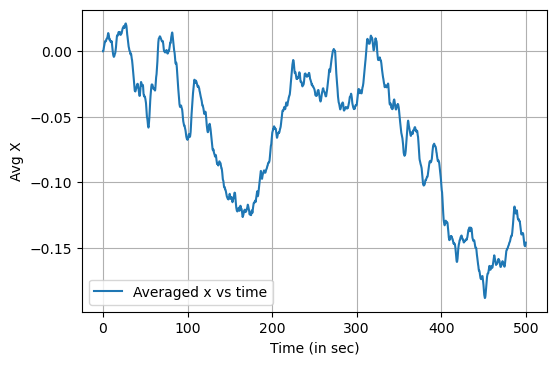

In [122]:
# Plotting averaged x vs time graph 
plt.plot(t1,x_avg, label="Averaged x vs time")                # plotting quantities with labels

# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

# Labelling axes
plt.xlabel("Time (in sec)")
plt.ylabel("Avg X")

# Plotting grid and legend for label
plt.grid()
plt.legend()
plt.show()

In [123]:
# To find the difference between max and min value of averaged X
delta_avg_x = np.max(x_avg) - np.min(x_avg)
print("Delta X = ", delta_avg_x)

Delta X =  0.20925872204522603


#### 2. Averaged $x^2$ vs time

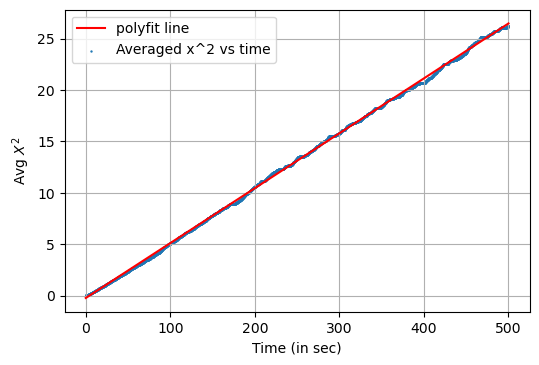

In [124]:
# Plotting averaged x^2 vs time graph 
plt.scatter(t1, x_sq_avg, label="Averaged x^2 vs time", s=0.5)                # plotting quantities with labels

# Plotting best fit line
ma, ca = np.polyfit(t1, x_sq_avg, 1)
plt.plot(t1, ma*t1 + ca, label="polyfit line", color='red')
# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

# Labelling axes
plt.xlabel("Time (in sec)")
plt.ylabel("Avg $X^2$")

# Plotting grid and legend for label
#plt.ylim(25,30)
plt.grid()
plt.legend()
plt.show()

### Finding out diffusion coefficient for the above data

In [125]:
m,c = fit(t1, x_sq_avg)
D = m/2                                                # From the Einstein Equation
print("Diffusion coefficient = ", D)

Diffusion coefficient =  0.026724207630499985


#### 3. Averaged $v$ vs time

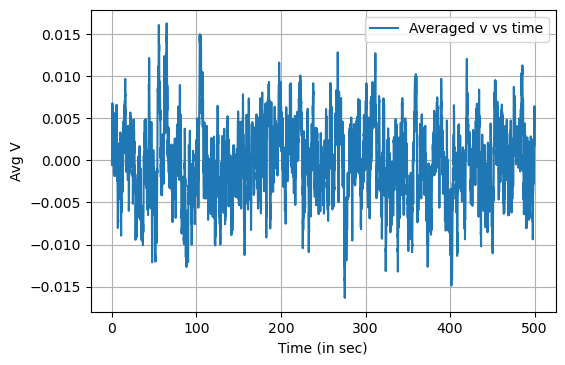

In [126]:
# Plotting averaged v vs time graph 
plt.plot(t1,v_avg, label="Averaged v vs time")                # plotting quantities with labels

# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

# Labelling axes
plt.xlabel("Time (in sec)")
plt.ylabel("Avg V")

# Plotting grid and legend for label
plt.grid()
plt.legend()
plt.show()

#### 4. Averaged $v^2$ vs time

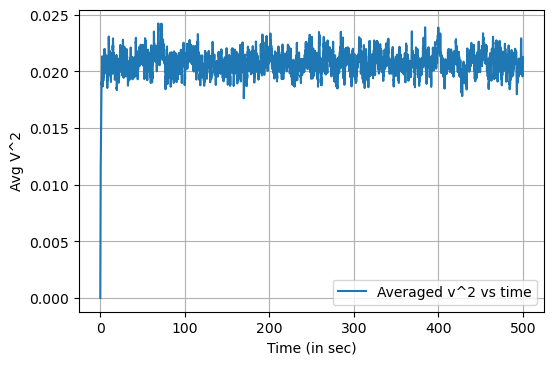

In [127]:
# Plotting averaged v^2 vs time graph 
plt.plot(t1,v_sq_avg, label="Averaged v^2 vs time")                # plotting quantities with labels

# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

# Labelling axes
plt.xlabel("Time (in sec)")
plt.ylabel("Avg V^2")

# Plotting grid and legend for label
plt.grid()
plt.legend()
plt.show()

### Creating arrays for $D$ (diffusion coefficient) and $\gamma$ (damping coefficient)

In [128]:
%%time
x2_sq = np.empty([trials,int(T/dt)+1], float)                # 2D array for x^2 values

# setting range for gamma values (and no. of gamma values)
g_start = 0.5 
g_end = 3
g_values = 100
 
g2 = np.linspace(g_start, g_end, g_values)                # creating gamma values array

D = np.empty(len(g2))                                     # creating array for D values


for j in range(len(g2)):                                  # since no. of gamma values = len(g2)                          
    for i in range(trials):                               # since no. of rows in the 2D array = no. of trials
        t2, x2, v2, e2 = rk4_new(Xin, Vin, T, dt, g2[j])  # generating values for T,X,V
        xsq = np.square(x2)                               # Squaring & storing X values
        x2_sq[i] = xsq                                    # transferring x^2 values from "i"th trial to "i"th row of array
        
    x2_sq_avg = np.mean(x2_sq, axis=0)                    # averaging columns to generate mean 'x^2' values
    M,C = fit(t2,x2_sq_avg)                               # extracting slope & intercept of best fit line for data
    D[j] = M/2                                            # Filling D values as slope/2

Wall time: 18.8 s


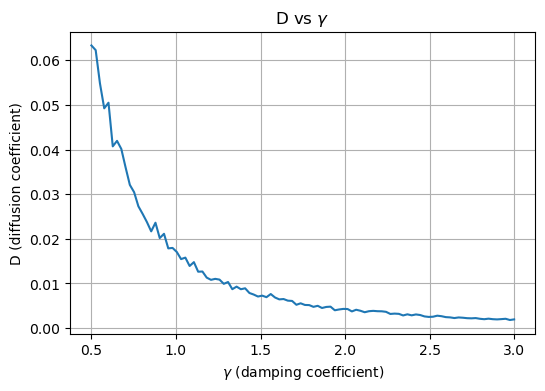

In [138]:
#rt_D = np.sqrt(D)
plt.plot(g2,D)
#plt.plot(g2, 0.017*1/g2**2)                  # Plot this to get the best fit plot (done by trial and error)
#plt.plot(g2, D - 0.017/g2**2)                # Plot this to get the deviation graph

# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

# Labelling axes
plt.xlabel("$\gamma$ (damping coefficient)")
plt.ylabel("D (diffusion coefficient)")
plt.title("D vs $\gamma$")

# Plotting grid and legend for label
plt.grid()
plt.show()

#print(D - 0.017/g2**2)

#### Plotting the log-log graph 

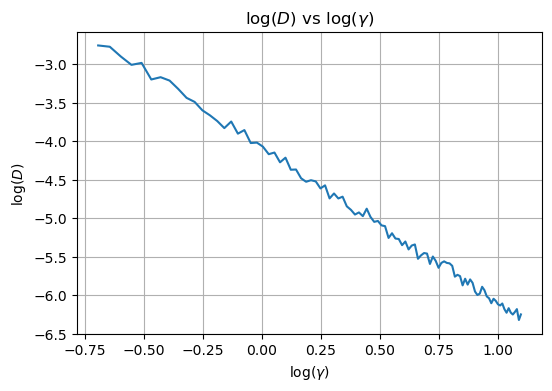

In [139]:
#rt_D = np.sqrt(D)
plt.plot(np.log(g2),np.log(D))
#plt.plot(g2,rt_D)

# Code to set plot dpi to 100 and background to white
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

# Labelling axes
plt.xlabel("$\log(\gamma)$")
plt.ylabel("$\log(D)$ ")
plt.title("$\log(D)$ vs $\log(\gamma)$")

# Plotting grid and legend for label
plt.grid()
plt.show()

In [140]:
m2,c2 = np.polyfit(np.log(g2),np.log(D), 1)                                # Getting the polyfit slope
print("D is directly proportional to gamma raised to the power", m2)

D is directly proportional to gamma raised to the power -2.0105690968218557
